# 環境構築

In [1]:
# !pip install keras-tuner --upgrade

In [10]:
pip list

Package                       Version
----------------------------- ------------------------
absl-py                       1.0.0
alembic                       1.8.1
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.0.5
astunparse                    1.6.3
attrs                         22.1.0
autopage                      0.5.1
backcall                      0.2.0
beautifulsoup4                4.11.1
bleach                        5.0.1
cachetools                    5.2.0
certifi                       2022.6.15
cffi                          1.15.1
charset-normalizer            2.1.0
clang                         13.0.1
click                         8.0.4
cliff                         4.0.0
cloudpickle                   2.1.0
cmaes                         0.8.2
cmake-setuptools              0.1.3
cmd2                          2.4.2
colorlog                      6.7.0
cuda-python                   11.6.0
cudf                          22

# ライブラリのインポート

### ローカル用

In [1]:
!pwd

/mnt/MachineLearning/MLTrial


In [3]:
import pprint
import sys
sys.path.append("/mnt/MachineLearning")
# sys.path.append("/home/i9-10920x/anaconda3/pkgs/tensorflow-base-2.8.1-cuda110py39h0baf056_0/lib/python3.9/site-packages")
# sys.path.append("/home/i9-10920x/anaconda3/pkgs/tensorflow-base-2.9.1-mkl_py310h353358b_0/lib/python3.10/site-packages")
pprint.pprint(sys.path)

['/mnt/MachineLearning/MLTrial',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/mnt/MachineLearning']


In [4]:
%matplotlib inline
import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import cv2
from scipy import interpolate
from modules import show_mod

In [7]:
#読み込むデータのパスの設定
current_dir_path = os.getcwd()
data_path = os.path.join(current_dir_path,"/mnt/MachineLearning/data")
input_list = glob.glob(data_path+"/*"+"/inputdata.csv")
output_list = glob.glob(data_path+"/*"+"/data"+"/*"+"/risk_dist.csv")
num_input = len(input_list)
num_output = len(output_list)

# データの前処理

## データの読み込み

In [8]:
#inputの読み込み
df_input = {}
for i in range(int(num_input)):
    input_fname = input_list[i]
    df_input[i] = pd.read_csv(input_fname, index_col="case_name")

df_input = pd.concat([df_input[i] for i in range(int(num_input))])

In [ ]:
#排気口位置a,b,offをダミー変数化
dummies = pd.get_dummies(df_input['exhaust'])
df_input.drop("exhaust", axis=1, inplace=True)
df_input = pd.concat([df_input, dummies], axis=1)
df_input = df_input.reindex(columns=['aircon','ventilation','a','b','off'
          ,'1_x','1_y','1_z','1_angle','2_x','2_y','2_z','2_angle','3_x','3_y','3_z','3_angle'
          ,'4_x','4_y','4_z','4_angle','5_x','5_y','5_z','5_angle',"office_size_x","office_size_y"
          ,"aircon_position_x","aircon_position_y"])

In [ ]:
#outputの読み込み
num_row = np.empty((num_output))
num_column = np.empty((num_output))
for i in range(num_output):
    np_temp = np.loadtxt(output_list[i], delimiter=",", dtype=np.float32)
    num_row[i] = np_temp.shape[0]
    num_column[i] = np_temp.shape[1]
    
max_num_row = int(max(num_row))
max_num_column = int(max(num_column))

## 補間法を用いたデータのリサイズ

In [ ]:
#bilinear method
def resize_bilinear(src, row, column):
    reszd = np.empty((row, column))
    scale_row = row / src.shape[0]
    scale_column = column / src.shape[1]
    
    for yd in range(row):
        for xd in range(column):
            x, y = xd / scale_column, yd / scale_row
            ox, oy = int(x), int(y)
                        
            if ox > src.shape[1] - 2:
                ox = src.shape[1] - 2
                x -= 1
            if oy > src.shape[0] - 2:
                oy = src.shape[0] - 2
                y -= 1
            
            dx = x - ox
            dy = y - oy
            
            reszd[yd, xd] = (1 - dx) * (1 - dy) * src[oy, ox] + dx * (1 - dy) * src[oy, ox + 1] + \
            (1 - dx) * dy * src[oy + 1, ox] + dx * dy * src[oy + 1, ox + 1]
            
    return reszd

In [ ]:
#データのリサイズ（自作のバイリニア補間）
np_output = np.empty((num_output, max_num_row, max_num_column))
for i in range(num_output):
    np_temp = np.loadtxt(output_list[i], delimiter=",", dtype=np.float32)
    np_reszd =  resize_bilinear(np_temp, max_num_row, max_num_column)
    np_output[i] = np_reszd

In [ ]:
#OpenCVによるデータのリサイズ、現状使っていない

# for i in range(num_output):
#     np_temp = np.loadtxt(output_list[i], delimiter=",", dtype=np.float32)
#     scale_row = max_num_row / np_temp.shape[0]
#     scale_column = max_num_column / np_temp.shape[1]
#     np_resz = cv2.resize(np_temp, (np_temp.shape[1]*scale_column, np_temp.shape[0]*scale_row), interpolation=cv2.INTER_LINEAR)

## パディングによるリサイズ

In [ ]:
#−１パディングでサイズ合わせ
np_output = np.empty((num_output, max_num_row, max_num_column))
for i in range(num_output):
    np_temp = np.loadtxt(output_list[i], delimiter=",", dtype=np.float32)
    np_padding = np.pad(array=np_temp, pad_width=[(0, max_num_row - np_temp.shape[0]), (0,  max_num_column - np_temp.shape[1])],\
                        mode="constant", constant_values = (-1) )
    np_output[i] = np_padding

In [ ]:
# nanパディングの遺産
# np_output = np.empty((max_num_row, max_num_column))
# for i in range(num_output):
#     np_temp = np.loadtxt(output_list[i], delimiter=",", dtype=np.float32)
    
#     if np_temp.shape[0] < max_num_row :
#         nan = np.empty((max_num_row - int(np_temp.shape[0]), max_num_column))
#         nan[max_num_row - int(np_temp.shape[0]), max_num_column] = np.nan
#         np.insert(np_temp, int(np_temp.shape[0]) + 1 : max_num_row, :] = np.nan
#     if np_temp.shape[1] < max_num_column :
#         np_temp[:, int(np_temp.shape[1]) + 1:] = np.nan 
    
#     np_output = np.append(np_output, np_temp, axis=0)
    
# output = []
# for i in range(num_output):
#     with open (output_list[i], "r") as csv_fname:
#         reader = csv.reader(csv_fname)
#         temp_list = [row for row in reader]
#         output.append(temp_list)

## outputデータの確認

In [ ]:
output_list[25]

'/home/i9-10920x/konishi/MLTrial/data/office2/data/960_164_aout/risk_dist.csv'

In [ ]:
np_temp = np.loadtxt(output_list[25], delimiter=",", dtype=np.float32)

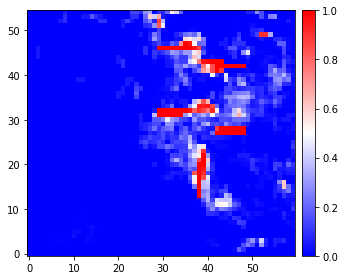

In [ ]:
show_mod.show_image(np_temp ,cbar=True)

In [ ]:
#ケース名の取得
case_name_list = []
for path_name in output_list:
    path_name_list = path_name.split('/')#ディレクトリ名を区切り文字単位で切り取ってリストに格納
    case_name_list.append(path_name_list[-4] + "_" +path_name_list[-2])

In [5]:
#可視化用カラーマップの作成
# cmap = show_mod.make_colormap(["gray", "gray", "blue", "white", "red"])
# cmap = show_mod.make_colormap(["blue", "white", "red"])
cmap = show_mod.make_colormap(["black", "white"])

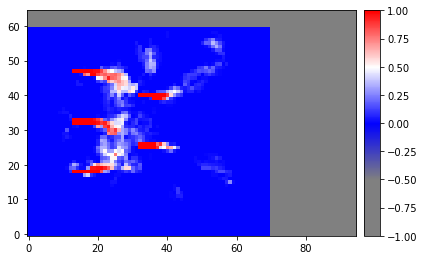

In [ ]:
#選んだ1個をプロット
show_mod.show_image(np_output[25], cbar=True, cmap=cmap)

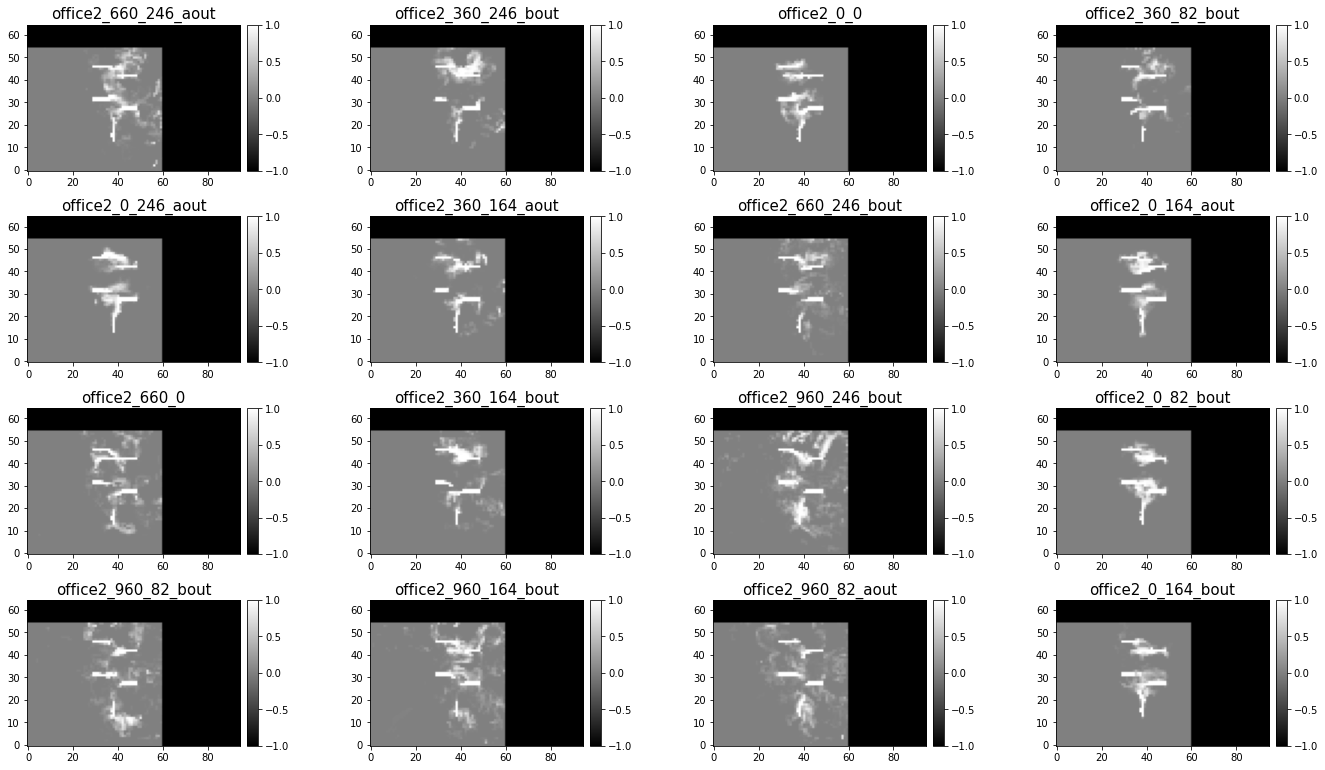

In [ ]:
#複数プロット
show_mod.show_images(np_output, title_name=case_name_list, row=4, column=4, cbar=True, cmap=cmap)

## 機械学習を行うための前処理

In [6]:
from sklearn import preprocessing

In [9]:
df_input

,aircon,ventilation,exhaust,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,...,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y,aircon_position_x,aircon_position_y
case_name,,,,,,,,,,,,,,,,,,,,,
office2_960_164_aout,960,164,a,3.780,1.265,1.255,90.0,4.76,2.74,1.255,...,1.255,0.0,2.84,3.14,1.255,0.0,6.0,5.5,3.00,2.75
office2_960_82_bout,960,82,b,3.780,1.265,1.255,90.0,4.76,2.74,1.255,...,1.255,0.0,2.84,3.14,1.255,0.0,6.0,5.5,3.00,2.75
office2_960_246_bout,960,246,b,3.780,1.265,1.255,90.0,4.76,2.74,1.255,...,1.255,0.0,2.84,3.14,1.255,0.0,6.0,5.5,3.00,2.75
office2_660_164_bout,660,164,b,3.780,1.265,1.255,90.0,4.76,2.74,1.255,...,1.255,0.0,2.84,3.14,1.255,0.0,6.0,5.5,3.00,2.75
office2_0_164_bout,0,164,b,3.780,1.265,1.255,90.0,4.76,2.74,1.255,...,1.255,0.0,2.84,3.14,1.255,0.0,6.0,5.5,3.00,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office28_960_82_bout,960,82,b,1.265,3.820,1.255,0.0,2.93,2.84,1.255,...,1.255,270.0,2.97,4.76,1.255,270.0,9.5,6.0,4.75,3.00
office28_660_0,660,0,off,1.265,3.820,1.255,0.0,2.93,2.84,1.255,...,1.255,270.0,2.97,4.76,1.255,270.0,9.5,6.0,4.75,3.00
office28_360_246_aout,360,246,a,1.265,3.820,1.255,0.0,2.93,2.84,1.255,...,1.255,270.0,2.97,4.76,1.255,270.0,9.5,6.0,4.75,3.00


In [ ]:
#入力データの選択(オフィスサイズとエアコン位置が被っていると思うので削除)
df_input.drop(df_input.columns[27:], axis=1, inplace=True)

In [ ]:
#入力データの標準化
stdscaler = preprocessing.StandardScaler()
stdscaler.fit(df_input)
input_std = stdscaler.transform(df_input)
df_input_std = df_input.copy()
for i in range(int(input_std.shape[1])):
    df_input_std.iloc[:, i] = input_std[:, i]

In [ ]:
#output 3D to 2D
df_output_2D = pd.DataFrame(np_output.reshape(-1, max_num_row*max_num_column))
df_output_2D.set_axis(case_name_list, axis=0, inplace=True)#case_name to index
df_output_2D = df_output_2D.reindex(index=df_input.index)#input.index = output.index
df_output_2D.shape

(263, 6175)

# 機械学習の実装

In [7]:
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"#0でオフ1でオン
os.environ["CUDA_VISIBLE_DEVICES"] = "0"#-1でオフgpu番号で使用するgpu指定

In [8]:
#機械学習の実装
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
# import keras_tuner as kt
import IPython

## GPUの確認

In [21]:
## keras をインポート
import tensorflow as tf
from tensorflow import keras as kr
## 結果の評価　数値計算用
import numpy as np

## trainX 学習用データ、trainY 正解データ、testX テスト用データ、testY 正解データ
(trainX, trainY), (testX, testY) = kr.datasets.mnist.load_data()

## 形式変換
# テストデータを変換
trainX = trainX.reshape(60000, 784)
trainX = trainX/255.
testX = testX.reshape(10000, 784)
testX = testX/255.
# 正解データを変換
trainY = kr.utils.to_categorical(trainY, 10)
testY = kr.utils.to_categorical(testY, 10)

## モデル構築
# 中間層１層　全結合型
model = kr.models.Sequential()
model.add(kr.layers.Dense(units=256, input_shape=(784,), activation='relu'))
model.add(kr.layers.Dropout(0.5))

# 出力層
model.add(kr.layers.Dense(units=10, activation='softmax'))

## 学習
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(trainX, trainY, batch_size=100, epochs=20, validation_split=0.1, verbose=1)

## テスト
result = model.predict(testX)

## 結果を表示
pred = np.array(result).argmax(axis=1)
print(pred)
label=testY.argmax(axis=1)
print(label)
accuracy = np.mean(pred == label, axis=0)
print(accuracy)

Epoch 1/20


2022-10-03 04:06:07.566558: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 169344000 exceeds 10% of free system memory.
2022-10-03 04:06:07.674777: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 169344000 exceeds 10% of free system memory.


540/540 [==============================] - 3s 5ms/step - loss: 1.2384 - accuracy: 0.6459 - val_loss: 0.5818 - val_accuracy: 0.8850
Epoch 2/20
540/540 [==============================] - 2s 5ms/step - loss: 0.6605 - accuracy: 0.8134 - val_loss: 0.4014 - val_accuracy: 0.9072
Epoch 3/20
540/540 [==============================] - 2s 5ms/step - loss: 0.5374 - accuracy: 0.8475 - val_loss: 0.3366 - val_accuracy: 0.9175
Epoch 4/20
540/540 [==============================] - 2s 4ms/step - loss: 0.4729 - accuracy: 0.8647 - val_loss: 0.3013 - val_accuracy: 0.9247
Epoch 5/20
540/540 [==============================] - 2s 5ms/step - loss: 0.4323 - accuracy: 0.8769 - val_loss: 0.2784 - val_accuracy: 0.9272
Epoch 6/20
540/540 [==============================] - 2s 5ms/step - loss: 0.4068 - accuracy: 0.8834 - val_loss: 0.2626 - val_accuracy: 0.9293
Epoch 7/20
540/540 [==============================] - 2s 5ms/step - loss: 0.3875 - accuracy: 0.8899 - val_loss: 0.2485 - val_accuracy: 0.9330
Epoch 8/20
540/54

## トレーニング，テストデータの振り分け

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
#特定のofficeだけテストデータにする
target_office_name = ["office1", "office2", "office3"]
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_input_std.index.str.extract("(office+[0-9]{1,2})").to_numpy()
#リスト内包表記
test_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == target_office_name)]
#test_data_index以外をtrain_data_indexとする
train_data_bool = np.ones(office_list.shape[0], dtype = bool)
train_data_bool[test_data_index] = False
train_data_index = np.arange(office_list.shape[0])[train_data_bool]

In [ ]:
#トレーニングデータ、テストデータの振り分け
train_data = df_input_std.iloc[train_data_index]
test_data = df_input_std.iloc[test_data_index]
train_target = df_output_2D.iloc[train_data_index]
test_target = df_output_2D.iloc[test_data_index]

In [ ]:
#トレーニングデータをシャッフルしておかないとk分割交差検証の精度がおかしくなる
train_data = train_data.sample(frac = 1, random_state = 0)
train_target = train_target.sample(frac = 1, random_state = 0)

In [ ]:
y_test_office_size = int(num_row[test_data_index[1]])
x_test_office_size = int(num_column[test_data_index[1]])
output_size = x_test_office_size*y_test_office_size

## 単純な回帰モデル

In [ ]:
#モデルのビルド
def build_model(train_data, optimizer, output_size):
    model = keras.Sequential()
    model.add(Dense(64, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
#     model.add(Dense(64, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001)))
#     model.add(BatchNormalization())
#     model.add(Activation("relu"))
    model.add(Dense(output_size, kernel_initializer="he_normal"))
    model.build(input_shape=(train_data.shape))
    model.summary()
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [ ]:
#全データを使って訓練してみる
optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.99)
model = build_model(train_data, optimizer, max_num_column*max_num_row)
# model.fit(train_data, train_target, epochs=500, batch_size=16, verbose=1)
es = EarlyStopping(monitor="val_mae", patience=100, verbose=0)#定めたパラメータの最小値更新が行われなければ打ち切り
hist = model.fit(train_data, train_target, epochs=3000, batch_size=16, verbose=1, validation_data=(test_data, test_target), callbacks=[es])
val_mse, val_mae = model.evaluate(test_data, test_target, verbose=0)
print('test_mse: {:.4f}, test_mae: {:.4f}'.format(val_mse, val_mae))

## keras_tunerを導入した回帰モデル

In [ ]:
#keras_tunerを使用したハイパーパラメータ調整
def build_model(hp):
    model = keras.Sequential()
    
    hp_num_Dense = hp.Int("num_Dense", min_value=2, max_value=5, step=1)
    hp_Dropout_switch = hp.Choice("Dropout_switch", values=[True, False])
    
    if (hp_Dropout_switch):
        for i in range(hp_num_Dense):
            hp_units = hp.Int("units", min_value=32, max_value=128, step=32)
            hp_Dropout_rate = hp.Choice("rate", values=[0.3, 0.4, 0.5])
            model.add(Dense(units=hp_units, kernel_initializer="he_normal"))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(Dropout(rate=hp_Dropout_rate))
    else:
        for i in range(hp_num_Dense):
            hp_units = hp.Int("units", min_value=32, max_value=128, step=32)
            model.add(Dense(units=hp_units, kernel_initializer="he_normal"))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
    
    model.add(Dense(max_num_column*max_num_row, kernel_initializer="he_normal"))
    
    hp_learning_rate = hp.Choice("learning_rate", values=[1.e-2, 1.e-3, 1.e-4])
    model.compile(optimizer=optimizers.RMSprop(learning_rate=hp_learning_rate, rho=0.99), loss='mse', metrics=['mae'])
    return model

In [ ]:
#keras_tunerのログが残っていれば削除
import shutil
output_log_path = "output_log/"

if os.path.exists(output_log_path):
    shutil.rmtree(output_log_path)

#tunerのインスタンス化
tuner = kt.Hyperband(build_model, objective="val_mae", max_epochs=500, directory="output_log")

In [ ]:
#トレーニングステップごとにトレーニング出力をクリアにするコールバック
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)

In [ ]:
tuner.search(train_data, train_target, epochs=500, batch_size=32,
             validation_data=(test_data, test_target), callbacks=[ClearTrainingOutput()])

In [ ]:
#チューニングによって得られたベストなハイパーパラメータ
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Dropout_switch is {best_hps.get("Dropout_switch")}\n
num_Dense is {best_hps.get("num_Dense")}\n
units is {best_hps.get("units")}\n
Dropout_rate is {best_hps.get("rate")}\n
learning_rate is {best_hps.get("learning_rate")}
        """)

In [ ]:
#最適なハイパーパラメータでモデルをビルドしてみる
model = tuner.hypermodel.build(best_hps)
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#全データを使って学習
es = EarlyStopping(monitor="val_mae", patience=100, verbose=0)#定めたパラメータの最小値更新が行われなければ打ち切り
hist = model.fit(train_data, train_target, epochs=3000, batch_size=32, verbose=1, validation_data=(test_data, test_target), callbacks=[es])
val_mse, val_mae = model.evaluate(test_data, test_target, verbose=0)
print('test_mse: {:.4f}, test_mae: {:.4f}'.format(val_mse, val_mae))

## 転置畳み込み層のみのモデル

In [ ]:
#DCGANの生成器のみ作ってみる
def build_generator(input_dim, optimizer):
    model = keras.Sequential()
    
    #全結合層と形状直し
    model.add(Dense(256 * 7 * 7, input_dim=input_dim))
    model.add(Reshape((7, 7, 256)))
    
    #転置畳み込み層１
    model.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    #転置畳み込み層2
    model.add(Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    #転置畳み込み層3
    model.add(Conv2DTranspose(16, kernel_size=(3,3), strides=(2,3), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    #転置畳み込み層4
    model.add(Conv2DTranspose(8, kernel_size=(5,5), strides=(1,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    #転置畳み込み層5
    model.add(Conv2DTranspose(8, kernel_size=(3,4), strides=(1,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    #転置畳み込み層6
    model.add(Conv2DTranspose(1, kernel_size=(4,5), strides=(1,1)))
    model.add(Activation("tanh"))
    
    model.summary()
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [ ]:
#target 2D to 3D
train_target_2D = train_target.to_numpy()
train_target_3D = train_target_2D.reshape(-1, max_num_row, max_num_column, 1)
test_target_2D = test_target.to_numpy()
test_target_3D = test_target_2D.reshape(-1, max_num_row, max_num_column, 1)
test_target_3D.shape

(28, 65, 95, 1)

In [ ]:
#全データを使用してモデルの学習
# optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.99)
optimizer = optimizers.Adam(learning_rate=0.001)
model = build_generator(input_dim=train_data.shape[1], optimizer=optimizer)
es = EarlyStopping(monitor="val_mae", patience=100, verbose=0)#定めたパラメータの最小値更新が行われなければ打ち切り
hist = model.fit(train_data, train_target_3D, epochs=1000, batch_size=16, verbose=1, validation_data=(test_data, test_target_3D), callbacks=[es])
val_mse, val_mae = model.evaluate(test_data, test_target_3D, verbose=0)
print('test_mse: {:.4f}, test_mae: {:.4f}'.format(val_mse, val_mae))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             351232    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 64)       147520    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 32)      

## DCGAN（深層畳み込みGAN）

### mnistでテスト


In [11]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-10-03 04:33:08.988357: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-03 04:33:10.149958: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 04:33:10.324369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1931] Ignoring visible gpu device (device: 1, name: Quadro P1000, pci bus id: 0000:65:00.0, compute capability: 6.1) with core count: 5. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2022-10-03 04:33:10

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1612614243167340789
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9958785024
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17537892174726656138
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:17:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [10]:
from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 646342837247148737
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9918414848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6525216241921789385
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:17:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2022-10-03 02:17:48.082438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 9458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:17:00.0, compute capability: 8.6


In [12]:
#生成器に与えるランダムな数列
ran_normal_dim = 100

In [13]:
#DCGANの生成器(mnist用)
def build_generator(input_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=input_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

In [14]:
#DCGANの識別器
def build_discriminator(input_dim):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=input_dim,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=input_dim,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=input_dim,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [15]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [16]:
#mnistでテストしてみる
from keras.datasets import mnist
img_rows = 28
img_columns = 28
channels = 1
img_shape = (img_rows, img_columns, channels)

(x_train, _), (_, _) = mnist.load_data()
x_train = x_train / 127.5 - 1.0
x_train = np.expand_dims(x_train, axis=3)

In [17]:
# Build and compile the Discriminator
optimizer = optimizers.Adam(learning_rate=0.001)
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(ran_normal_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [18]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(train_data, iterations, batch_size, sample_interval):

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, train_data.shape[0], batch_size)
        imgs = train_data[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z, verbose=0)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z, verbose=0)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                    (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)
            # gen_imgs = generator.predict(z)
            # gen_imgs_3D = gen_imgs.reshape(-1 , img_rows, img_columns)
            # show_mod.show_images(gen_imgs_3D, row=4, column=4, cmap=cmap, cbar=True)

In [19]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, ran_normal_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

2022-10-03 02:19:50.696579: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500


1000 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.001979]
1/1 [==============================] - 0s 92ms/step
2000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.002939]
1/1 [==============================] - 0s 36ms/step
3000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.001790]
1/1 [==============================] - 0s 19ms/step
4000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.090496]
1/1 [==============================] - 0s 27ms/step
5000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.014990]
1/1 [==============================] - 0s 27ms/step
6000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.044893]
1/1 [==============================] - 0s 38ms/step
7000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.023348]
1/1 [==============================] - 0s 27ms/step
8000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.018106]
1/1 [==============================] - 0s 17ms/step
9000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.014187]
1/1 [==============================] - 0s 13ms/step
10000 [D l

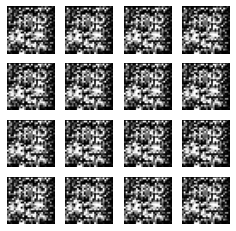

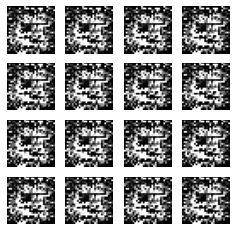

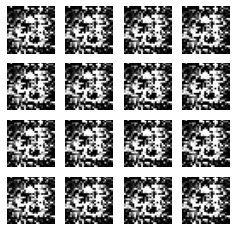

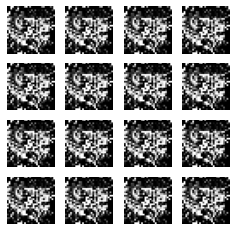

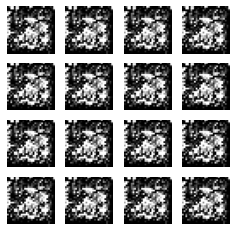

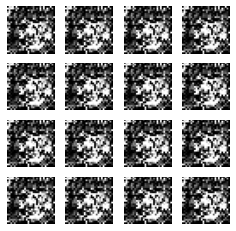

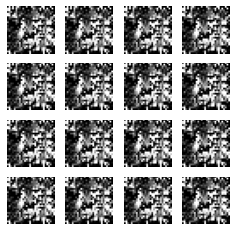

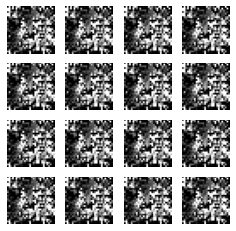

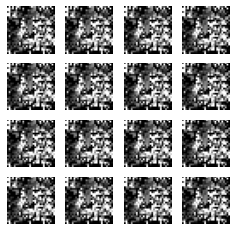

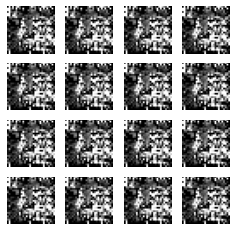

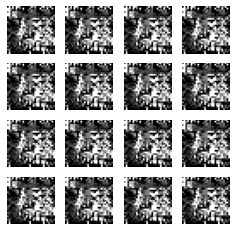

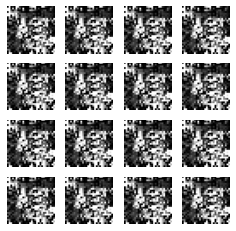

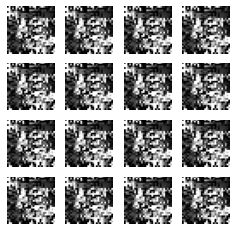

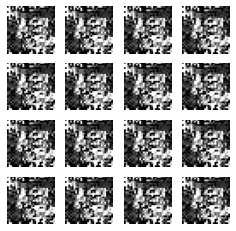

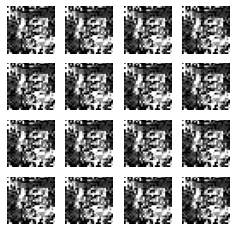

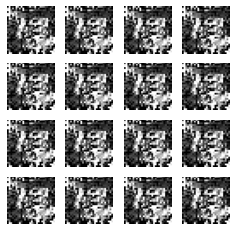

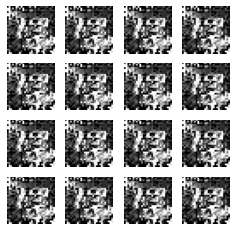

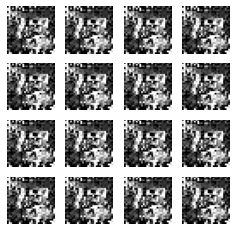

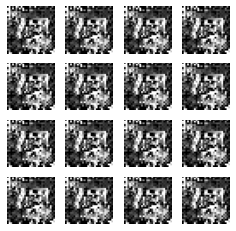

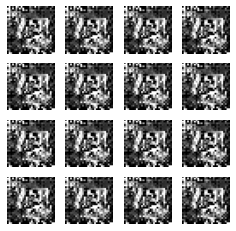

In [20]:
#ハイパーパラメータ設定
iterations = 20000
batch_size = 128#訓練を行うバッチサイズ指定
sample_interval = 1000
train(train_data = x_train, iterations=iterations, batch_size=batch_size, sample_interval=sample_interval)

### 感染確率分布に導入

In [ ]:
#生成器に与えるランダムな数列
ran_normal_dim = 100

In [ ]:
#DCGANの生成器
def build_generator(input_dim):
    model = keras.Sequential()
    
    #全結合層と形状直し
    model.add(Dense(256 * 7 * 7, input_dim=input_dim))
    model.add(Reshape((7, 7, 256)))
    
    #転置畳み込み層１
    model.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    #転置畳み込み層2
    model.add(Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    #転置畳み込み層3
    model.add(Conv2DTranspose(16, kernel_size=(3,3), strides=(2,3), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    #転置畳み込み層4
    model.add(Conv2DTranspose(8, kernel_size=(5,5), strides=(1,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    #転置畳み込み層5
    model.add(Conv2DTranspose(8, kernel_size=(3,4), strides=(1,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    #転置畳み込み層6
    model.add(Conv2DTranspose(1, kernel_size=(4,5), strides=(1,1)))
    model.add(Activation("tanh"))
    
    model.summary()
    return model

In [ ]:
#DCGANの識別器
def build_discriminator(input_dim):
    model = keras.Sequential()
    
    #28*28*1の画像を14*14*32のテンソルにする畳み込み層
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=input_dim, padding="same"))
    model.add(LeakyReLU(alpha=0.01))

    #畳み込み層
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=input_dim, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    #畳み込み層
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=input_dim, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    #画像の真偽予測を行うシグモイド関数
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    model.summary()
    return model

In [ ]:
#DCGANの構築
def build_gan(generator, discriminator):

    model = keras.Sequential()

    #生成器と識別器を組み合わせる
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
#識別器の構築とコンパイル
optimizer = optimizers.Adam(learning_rate=0.001)
# discriminator = build_discriminator([max_num_row, max_num_column, 1])
discriminator = build_discriminator(img_shape)
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
#生成器の構築
generator = build_generator(ran_normal_dim)
#生成器の訓練中は識別器の重みやバイアスなどのパラメータは固定する
discriminator.trainable = False
#識別器を固定したまま生成器を訓練する
gan = build_gan(generator, discriminator)
gan.compile(loss="binary_crossentropy", optimizer=optimizer)

In [ ]:
#target 2D to 3D
train_target_2D = train_target.to_numpy()
train_target_3D = train_target_2D.reshape(-1, max_num_row, max_num_column, 1)
test_target_2D = test_target.to_numpy()
test_target_3D = test_target_2D.reshape(-1, max_num_row, max_num_column, 1)
test_target_3D.shape

(95, 65, 95, 1)

In [ ]:
np_output_2D = df_output_2D.to_numpy()
np_output_3D = np_output_2D.reshape(-1, max_num_row, max_num_column, 1)
np_output_3D.shape

(263, 65, 95, 1)

In [ ]:
#トレーニング
losses = []
accuracies = []
iteration_checkpoints = []

def train(train_data, iterations, batch_size, sample_interval):

    #本物と偽物のラベル
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        """
        識別器の学習
        """

        #トレーニングデータから訓練に使用するミニバッチを作成
        idx = np.random.randint(0, train_data.shape[0], batch_size)#トレーニングデータ全体からランダムにバッチサイズ分のデータを取ってくる
        imgs = train_data[idx]

        #生成器に与えるランダムな数列
        ran_normal = np.random.normal(0, 1, (batch_size, ran_normal_dim))
        gen_imgs = generator.predict(ran_normal)

        #識別器の学習(train_on_batchは全てのデータを用いて学習するのではなく追加したデータのみ用いて学習を行う)
        #train_on_batchは戻り値として学習の損失を表すスカラー値を返す(今回はlossとmetricsに指定したaccuracyのスカラー値のリスト)
        discriminator_loss_real = discriminator.train_on_batch(imgs, real)#本物の画像から本物のラベルであるとシグモイド関数によって予測する
        discriminator_loss_fake = discriminator.train_on_batch(gen_imgs, fake)#偽物の画像から偽物のラベルであるとシグモイド関数によって予測する
        #本物の画像を本物，偽物の画像を偽物と判断できれば下の値は良くなる
        #discriminator_loss_real,fakeには[loss, accuracy]が入っておりそれらの平均を取っている
        discriminator_loss, accuracy = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

        """
        生成器の学習
        """

        #生成器に与えるランダムな数列
        ran_normal = np.random.normal(0, 1, (batch_size, ran_normal_dim))
        gen_imgs = generator.predict(ran_normal)

        #生成器の学習
        #ganの学習は識別器を止めた状態で訓練を行うため実質生成器のみ訓練している
        #偽物の画像を与えてそれに対して識別器が本物であると判断するように訓練する
        generator_loss = gan.train_on_batch(ran_normal, real)
        
        #一定の学習毎に結果出力
        if (iteration + 1) % sample_interval == 0:

            #損失と正解値の保存(iterationは0から始まるが訓練ステップとしては1からの方が分かりやすいので+1)
            losses.append((discriminator_loss, generator_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            #学習結果の出力
            print("%d [Discriminator loss: %f, accuracy: %.2f%%][Generator loss: %f]"%(iteration + 1, discriminator_loss, 100.0 * accuracy, generator_loss))

            #生成したサンプル画像出力
            ran_normal = np.random.normal(0, 1, (batch_size, ran_normal_dim))
            gen_imgs = generator.predict(ran_normal)
            # gen_imgs_3D = gen_imgs.reshape(-1 , max_num_row, max_num_column)
            gen_imgs_3D = gen_imgs.reshape(-1 , img_rows, img_columns)
            show_mod.show_images(gen_imgs_3D, row=4, column=4, cmap=cmap, cbar=True)

In [ ]:
#ハイパーパラメータ設定
iterations = 20000
batch_size = 64#訓練を行うバッチサイズ指定
sample_interval = 1000
train(train_data = np_output_3D, iterations=iterations, batch_size=batch_size, sample_interval=sample_interval)

In [ ]:
#ハイパーパラメータ設定
iterations = 10000
batch_size = 64#訓練を行うバッチサイズ指定
sample_interval = 1000
train(train_data = test_target_3D, iterations=iterations, batch_size=batch_size, sample_interval=sample_interval)

In [ ]:
#ハイパーパラメータ設定
iterations = 10000
batch_size = train_data.shape[0]#訓練を行うバッチサイズ指定
sample_interval = 1000
train(iterations=iterations, batch_size=batch_size, sample_interval=sample_interval)

# 学習結果の評価

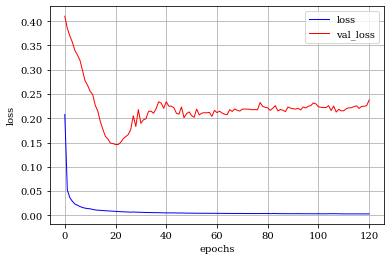

In [ ]:
#誤差関数の推移を見てみる
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

fig = plt.figure()
plt.rc("font", family="serif")
plt.plot(range(len(loss)), loss, color="blue", linewidth=1, label="loss")
plt.plot(range(len(val_loss)), val_loss, color="red", linewidth=1, label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")
plt.grid()
plt.show()

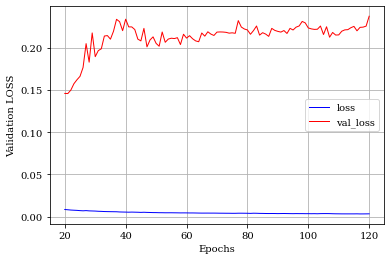

In [ ]:
#初めの数エポックの値が大きいのでそこを除いてみる
trim_position = 20
trim_loss_history = loss[trim_position:]
trim_val_loss_history = val_loss[trim_position:]
plt.plot(range(trim_position, len(trim_loss_history) + trim_position), trim_loss_history, "-b", linewidth=1, label="loss")
plt.plot(range(trim_position, len(trim_val_loss_history) + trim_position), trim_val_loss_history, "-r", linewidth=1, label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Validation LOSS")
plt.legend(loc="best")
plt.grid()
plt.show()

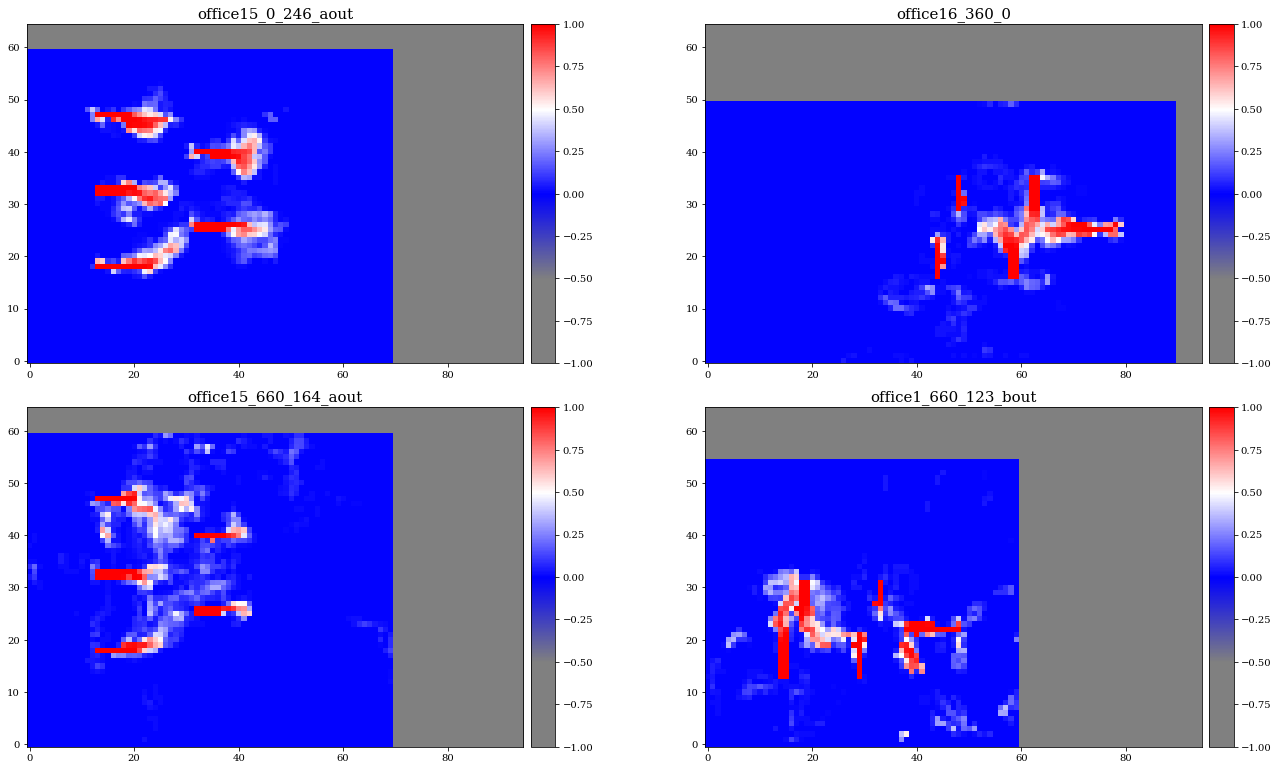

In [ ]:
#トレーニングデータの正解値の出力
train_target_2D = train_target.to_numpy()
train_target_3D = train_target_2D.reshape(-1 , max_num_row, max_num_column)
show_mod.show_images(train_target_3D,title_name=train_target.index, row=2, column=2, cmap=cmap, cbar=True)

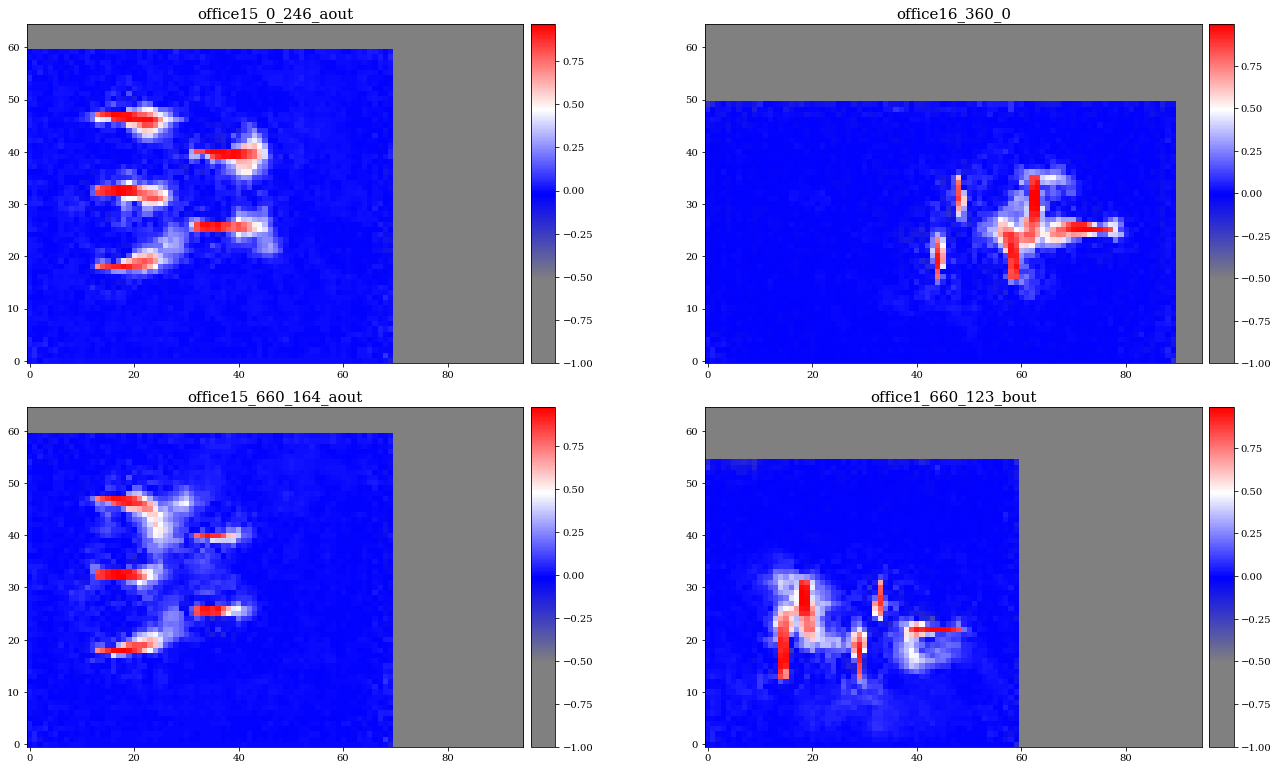

In [ ]:
#トレーニングデータの予測値の出力
predict_2D = model.predict(train_data, verbose=0)
predict_3D = predict_2D.reshape(-1 , max_num_row, max_num_column)
show_mod.show_images(predict_3D,title_name=train_target.index, row=2, column=2, cmap=cmap, cbar=True)

In [ ]:
predict_3D[1].max()

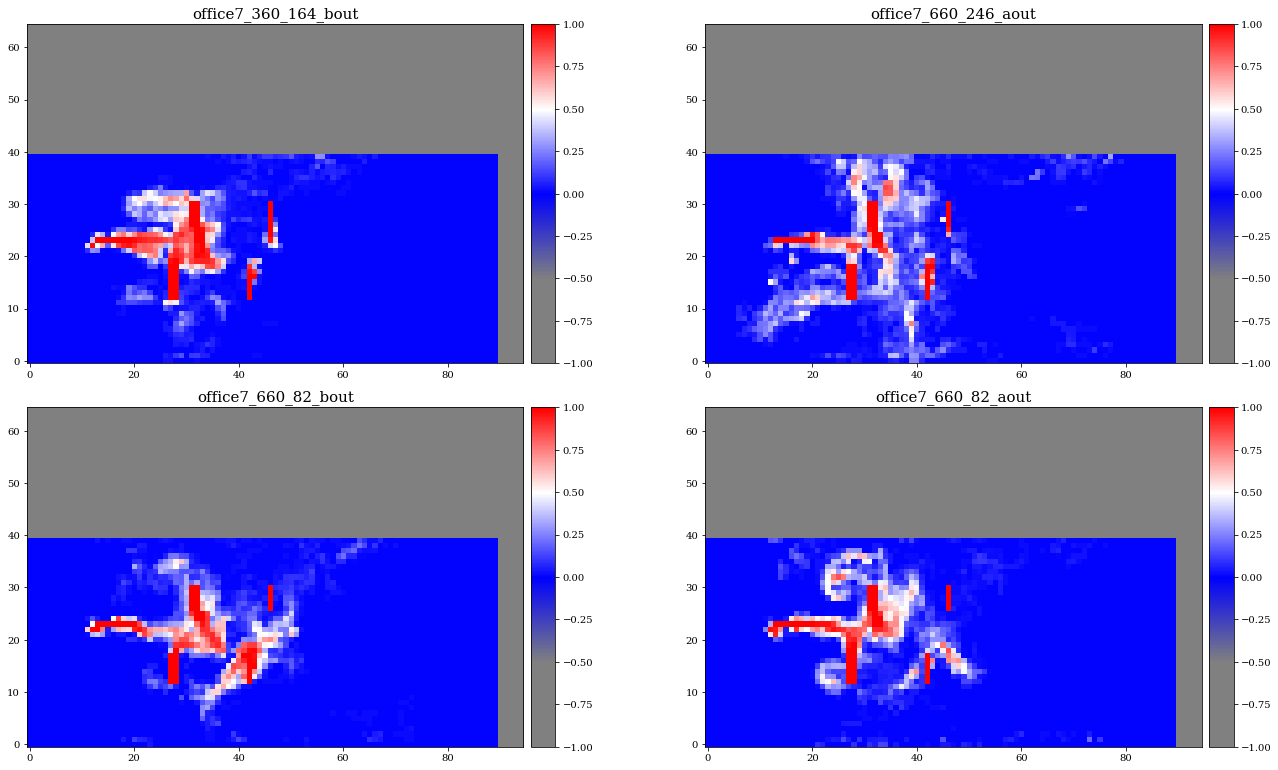

In [ ]:
#テストデータの正解値の出力
test_target_2D = test_target.to_numpy()
test_target_3D = test_target_2D.reshape(-1, max_num_row, max_num_column)
show_mod.show_images(test_target_3D,title_name=test_target.index, row=2, column=2, cmap=cmap, cbar=True)

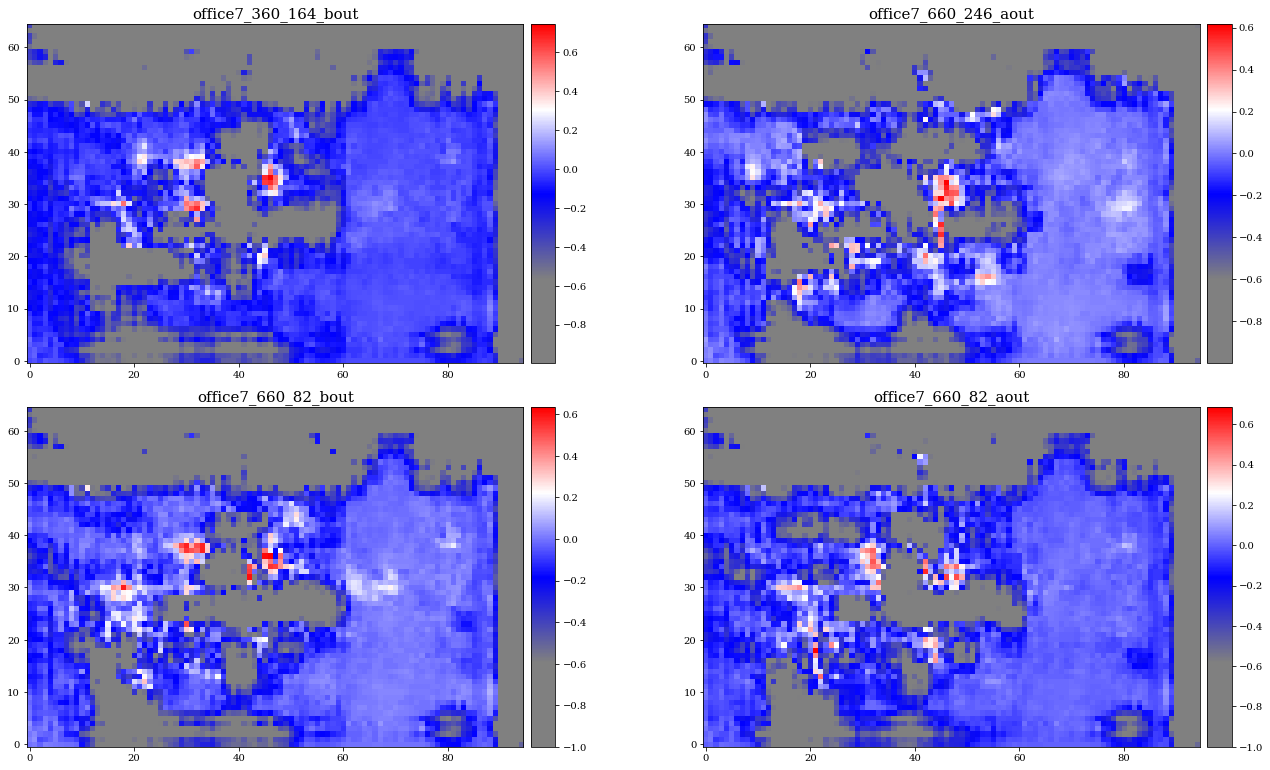

In [ ]:
#テストデータの予測値の出力
predict_2D = model.predict(test_data, verbose=0)
predict_3D = predict_2D.reshape(-1, max_num_row, max_num_column)
show_mod.show_images(predict_3D,title_name=test_target.index, row=2, column=2, cmap=cmap, cbar=True)